# Neural Network Training Code from Scratch
In this tutorial, you will discover how to implement the backpropagation algorithm for a neural network from scratch with Python. After completing this tutorial, you will know:
- How to forward-propagate an input to calculate an output.
- How to back-propagate error and train a network.
- How to apply the backpropagation algorithm to a real-world predictive modeling problem.

____

# Understanding the Dataset

We are using the 'accelerometer.csv' file as the dataset for creating our Artificial Neural Network. This dataset was generated for predicting motor failure modes for different weight configurations using ANNs. 

There are 5 attributes present in the dataset as follows - 

1. x : Acceleration in x direction
2. y : Acceleration in y direction
3. z : Acceleration in z direction
4. RPM : 
5. Weight configuration : Has values of 1, 2 and 3 to denote three different configurations that cause motor failure

We wish to use Neural Networks to classify data into these three failure mode configurations. Thus, we are working on a __classification problem__ with our classes being present in the __Weight Configuration__ column

## Importing the libraries and dataset

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("accelerometer.csv")
df.head()

,x,y,z,RPM,Weight Config
0,1.004,0.090,-0.125,20,1
1,1.004,-0.043,-0.125,20,1
2,0.969,0.090,-0.121,20,1
3,0.973,-0.012,-0.137,20,1
4,1.000,-0.016,-0.121,20,1


In [43]:
df.shape

(153000, 5)

In [44]:
#Classes in our target variable
df['Weight Config'].unique()

array([1, 2, 3], dtype=int64)

The range of values for the columns in our dataset are different. Thus It is generally a good practice to normalize input values to the range of the chosen activation function. In this case, the activation function used is sigmoid function that outputs values between 0 and 1. In the wheat seed dataset, the input values vary in scale and hence need to be normalized to the range of 0 and 1.

In [45]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.head()

,x,y,z,RPM,Weight Config
0,0.562891,0.505751,0.480381,0.0,0.0
1,0.562891,0.497437,0.480381,0.0,0.0
2,0.560703,0.505751,0.480716,0.0,0.0
3,0.560953,0.499375,0.479378,0.0,0.0
4,0.562641,0.499125,0.480716,0.0,0.0


We present the whole process through 4 steps :
1. Building the NN
2. Forward Propagation
3. Calculating Error
4. Backpropagation

# 1. Building the Neural Network
A neural network is organized into layers. The input layer is really just a row from our training dataset. The first real layer is the hidden layer. This is followed by the output layer that has one neuron for each class value.


## Number of neurons, weights and biases
First task in building the NN is to Calculate the number of input neurons. Number of input neurons is equal to the number of input variables (4 in this case). But, everytime the number of input variables may not be provided. Then, we have to extract it from the dataset. The number of input variables will be 1 less than the number of columns (as the final column represents the class variable). Hence, just slice a row from the dataset, calculate its length and subtract 1 from it.

In [46]:
# Number of input neurons
n_input = len(normalized_df.iloc[0])-1
n_input

4

Next, we fix the number of hidden neurons in the hidden layer (5 in this case).

In [47]:
# Number of hidden neurons
n_hidden = 5

Then, we fix the number of neurons in the output layer. Number of neurons in the output layer is equal to the number of unique values the class variable can take (3 in this case).

In [48]:
n_output = len(pd.unique(normalized_df['Weight Config']))
n_output

3

You can see that each neuron in the hidden layer has $n_{inputs} + 1$ weights, one for each input column in a dataset and an additional one for the bias. 

> So the total number of weights from input layer to hidden layer is $n_{hidden} (n_{inputs} + 1)$.

You can also see that each neuron in the output layer has $n_{hidden} + 1$ weights. This means that each neuron in the output layer connects to each neuron in the hidden layer and an additional one for the bias. 

> So the total number of weights from hidden layer to output layer is $n_{output} . (n_{hidden} + 1)$.

> Hence, total number of weights to be optimized in the NN is $n_{hidden} (n_{inputs} + 1) + n_{output}(n_{hidden} + 1)$.

In [50]:
# Number of weights from input layer to hidden layer 
# input_to_hidden = n_hidden X (n_inputs + 1) = 5 X (4 + 1) = 25
input_to_hidden = n_hidden * (n_input + 1)
input_to_hidden

25

In [51]:
# Number of weights from hidden layer to output layer
# hidden_to_output = n_output X (n_hidden + 1) = 3 X (5 + 1) = 18
hidden_to_output = n_output * (n_hidden + 1)
hidden_to_output

18

## Initialize weights
It is a good practice to initialize the network weights to small random numbers. In this case, we will use random numbers in the range of 0 to 1. We will organize layers as arrays and treat the whole network as an array of layers.

In [10]:
from random import random
network = list()

hidden_layer_weights = np.zeros((5,5))
for i in range(n_hidden):
    for j in range(n_input + 1):
        hidden_layer_weights[i,j] = random()
    
#hidden_layer_weights = np.asarray([[random() for i in range(n_input + 1)] for i in range(n_hidden)])
network.append(hidden_layer_weights)

# Weights of first neuron in hidden layer
hidden_layer_weights[0]

hidden_layer_weights

array([[0.31974432, 0.73800723, 0.45648306, 0.47700643, 0.85120776],
       [0.74391344, 0.75210287, 0.70634862, 0.46570561, 0.99918339],
       [0.28754272, 0.76581885, 0.60277315, 0.99570128, 0.48114054],
       [0.87224625, 0.62791782, 0.32445119, 0.89508715, 0.99971592],
       [0.98211976, 0.66816178, 0.27921971, 0.06291457, 0.1748827 ]])

In [11]:
output_layer_weights = np.asarray([[random() for i in range(n_hidden + 1)] for i in range(n_output)])
network.append(output_layer_weights)

# Weights of first neuron in output layer
output_layer_weights[0]

output_layer_weights

array([[0.13324626, 0.06745881, 0.43720079, 0.1484701 , 0.80803343,
        0.81128958],
       [0.89124622, 0.90273149, 0.21516128, 0.2620276 , 0.68384807,
        0.69312608],
       [0.33467901, 0.11002255, 0.78066162, 0.4371893 , 0.66543744,
        0.61890627]])

# Visualizing the NN

![alternatvie text](https://static.javatpoint.com/tutorial/artificial-neural-network/images/artificial-neural-network6.png)

Now that we know how to create and initialize a network, let’s see how we can use it to calculate an output.

## 2. Forward Propagation
We can calculate an output from a neural network by propagating an input signal through each layer until the output layer outputs its values. We call this forward-propagation.

It is the technique we will need to generate predictions during training that will need to be corrected, and it is the method we will need after the network is trained to make predictions on new data.

We can break forward propagation down into 2 parts:
1. Calculate net input to a neuron
2. Apply activation function

### Calculate net input to a neuron
In case of hidden layer, the net input to each neuron is calculated from the input data and the weights corresponding to that hidden neuron from input layer.

In [52]:
# Sample input data
# Take the first row of normalized data without the class label
sample_input = normalized_df.iloc[0, 0:4]
sample_input

x      0.562891
y      0.505751
z      0.480381
RPM    0.000000
Name: 0, dtype: float64

In [53]:
# Append '1' to sample input for bias
sample_input = np.append(sample_input,[1])
sample_input

array([0.56289072, 0.50575144, 0.48038149, 0.        , 1.        ])

In [54]:
# Calculate net input to each hidden neuron
hidden_net_input = list()
for layer in hidden_layer_weights:
    hidden_net_input.append(sum(layer*sample_input))
hidden_net_input = np.asarray(hidden_net_input)
hidden_net_input

array([9.54047484, 9.70029883, 9.70958548, 9.68368282, 9.57015089])

### Apply activation function
Once the net input to a neuron is calculated, we need to pass that through the activation function of that neuron to get the output of the neuron. Here, we use the sigmoid activation function for all the layers.

In [55]:
import math
hidden_layer_output = list()
hidden_net_input = [i*(-1) for i in hidden_net_input]
for each_net_input in hidden_net_input:
    hidden_layer_output.append(1 / (1 + math.exp(each_net_input)))
hidden_layer_output = np.asarray(hidden_layer_output)
hidden_layer_output

array([0.99992812, 0.99993874, 0.9999393 , 0.99993771, 0.99993022])

We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. The outputs of the hidden layer calculated above **hidden_layer_output** is used as inputs to the output layer.

In [56]:
# Append '1' to input for bias
output_layer_input = np.append(hidden_layer_output,[1])
output_layer_input

# Calculate net input to each output neuron
output_net_input = list()
for layer in output_layer_weights:
    output_net_input.append(sum(layer*output_layer_input))
output_net_input = np.asarray(output_net_input)
output_net_input

array([-0.70509611, -1.21404339, -0.7707452 ])

In [57]:
# Apply activation function
output_layer_output = list()
output_net_input = [i*(-1) for i in output_net_input]
for each_net_input in output_net_input:
    output_layer_output.append(1 / (1 + math.exp(each_net_input)))
output_layer_output = np.asarray(output_layer_output)
output_layer_output

array([0.33068332, 0.2289864 , 0.31631793])

## 3. Calculating Error
Convert the class label into binary patterns. There are 3 classes in this problem i.e. 3 types of seeds. These can be converted to their corresponding binary patterns :
- 1 --> [1,0,0]
- 2 --> [0,1,0]
- 3 --> [0,0,1]

The output layer has 3 neurons which output 3 values. These are stored in **output_layer_output**. Now, these values will be compared to the corresponding binary patterns to find the error/loss.

In [58]:
# Class label corresponding to sample_input
class_label = df.iloc[0,4]
class_label

1

In [59]:
# sample_output corresponding to class_label
if class_label == 1:
    sample_output = np.asarray([1,0,0])
elif class_label == 2:
    sample_output = np.asarray([0,1,0])
else:
    sample_output = np.asarray([0,0,1])
sample_output

array([1, 0, 0])

In [60]:
# Calculate error

# Difference between ideal output and actual output
diff = output_layer_output - sample_output

# Square of the difference
sqr = diff**2

# Error
error = sum(0.5*sqr)
error

0.3002383072806153

## 4. Backpropagation

### Calculating Gradient (Output Layer)

Now, we have to calculate how much this error changes with the change of each weight from hidden layer to output layer i.e. weights stored in **output_layer_weights**.

*[We are not showing the derivations of the following equations. These can be found in the slides]*

$\frac{\delta{E_{total}}}{\delta{w_{h1o1}}}={\delta_{o1}}*input_{h1o1}$

$\frac{\delta{E_{total}}}{\delta{w_{h1o1}}}=-(expected_{o1}-actual_{o1})*actual_{o1}(1-actual_{o1})*input_{h1o1}$

where, ${w_{h1o1}}$ is the weight of the connection between hidden neuron ${h_1}$ and output neuron ${o_1}$, ${expected_{o1}}$ is the ideal output from neuron ${o_1}$, ${actual_{o1}}$ is the calculated output from neuron ${o_1}$ and ${input_{h1o1}}$ is the input from neuron ${h_1}$ to ${o_1}$.

In [61]:
expected = sample_output[0]
actual = output_layer_output[0]
input_h1_to_o1 = hidden_layer_output[0]
delta_o1 = -(expected-actual)*actual*(1-actual)
gradient_h1_to_o1 = delta_o1*input_h1_to_o1
gradient_h1_to_o1

-0.14813045897327515

### Calculating Gradient (Hidden Layer)

Now, we have to calculate how much the error changes with the change of each weight from input layer to hidden layer i.e. weights stored in **hidden_layer_weights**.

*[We are not showing the derivations of the following equations. These can be found in the slides]*

$\frac{\delta{E_{total}}}{\delta{w_{i1h1}}}=\delta_{h1}*input_{i1h1}$

$\frac{\delta{E_{total}}}{\delta{w_{i1h1}}}=-(\delta_{o1}*{w_{h1o1}}+\delta_{o2}*{w_{h1o2}}+\delta_{o3}*{w_{h1o3}})*out_{h1}(1-out_{h1})*input_{i1h1}$

where ${w_{i1h1}}$ is the weight of the connection between input neuron ${i_1}$ and hidden neuron ${h_1}$, ${out_{h1}}$ is the output of hidden neuron ${h_1}$, ${input_{i1h1}}$ is the input from neuron ${i_1}$ to ${h_1}$.

First, calculate ${\delta_{o1}}$, ${\delta_{o2}}$ and ${\delta_{o3}}$ :

In [62]:
expected = sample_output
actual = output_layer_output
delta_o = -(expected-actual)*actual*(1-actual)
delta_o

array([-0.14814111,  0.04042792,  0.0684072 ])

Now, calculate ${\delta_{h1}}$

In [63]:
out_h1 = hidden_layer_output[0]
delta_h1 = -(sum(delta_o*output_layer_weights[:,0]))*out_h1*(1-out_h1)
delta_h1

3.206149484245214e-06

In [64]:
input_i1_to_h1 = sample_input[0]
gradient_i1_to_h1 = delta_h1*input_i1_to_h1
gradient_i1_to_h1

1.8047118002090461e-06

### Updating Weight (Output Layer)

${w_{h1o1}^{+}}={w_{h1o1}}-{\eta}*{\frac{\delta{E_{total}}}{\delta{w_{h1o1}}}}$

where ${\eta}$ is the learning rate.

In [25]:
learning_rate = 0.5
output_layer_weights[0,0] = output_layer_weights[0,0] - learning_rate*gradient_h1_to_o1
output_layer_weights[0,0]

0.1378320284293175

### Updating Weight (Hidden Layer)

${w_{i1h1}^{+}}={w_{i1h1}}-{\eta}*{\frac{\delta{E_{total}}}{\delta{w_{i1h1}}}}$

In [65]:
hidden_layer_weights[0,0] = hidden_layer_weights[0,0] - learning_rate*gradient_i1_to_h1
hidden_layer_weights[0,0]

3.0762697610747107

Now, that we have covered all the steps, let us put all of them together to train our NN.

# Combining all the steps together

In [66]:
import math
import numpy as np
import pandas as pd
from random import random

#Importing the dataset
df = pd.read_csv("accelerometer.csv")



In [67]:
#Creating our training dataset using 50,000 samples
sampled_input_data = df.sample(50000)
sampled_input_data

,x,y,z,RPM,Weight Config
14061,0.961,0.055,-0.109,40,1
43202,-0.613,-0.930,0.742,90,1
39391,-0.246,1.293,2.934,85,1
105199,0.973,0.117,-0.141,25,3
8193,1.004,-0.082,-0.148,30,1
...,...,...,...,...,...
117400,0.953,0.078,-0.141,45,3
102635,0.965,-0.117,-0.113,20,3
56637,0.973,0.043,-0.137,25,2
30837,0.941,0.008,-0.332,70,1


In [68]:
#Creating normalized dataframe
normalized_df=(sampled_input_data-sampled_input_data.min())/(sampled_input_data.max()-sampled_input_data.min())

In [69]:
normalized_df

,x,y,z,RPM,Weight Config
14061,0.560203,0.503563,0.494049,0.2500,0.0
43202,0.461803,0.441985,0.578457,0.8750,0.0
39391,0.484746,0.580958,0.795874,0.8125,0.0
105199,0.560953,0.507439,0.490875,0.0625,1.0
8193,0.562891,0.494999,0.490181,0.1250,0.0
...,...,...,...,...,...
117400,0.559702,0.505001,0.490875,0.3125,1.0
102635,0.560453,0.492811,0.493652,0.0000,1.0
56637,0.560953,0.502813,0.491272,0.0625,0.5
30837,0.558952,0.500625,0.471930,0.6250,0.0


In [70]:
#Build the ANN
n_input = len(normalized_df.iloc[0])-1
n_hidden = 5
n_output = len(pd.unique(normalized_df['Weight Config']))

#Initialize the weights
hidden_layer_weights = np.asarray([[random() for i in range(n_input + 1)] for i in range(n_hidden)])
output_layer_weights = np.asarray([[random() for i in range(n_hidden + 1)] for i in range(n_output)])

In [71]:
#Input data to our neural network
input_data = normalized_df.iloc[:,0:4]

In [72]:
input_data

,x,y,z,RPM
14061,0.560203,0.503563,0.494049,0.2500
43202,0.461803,0.441985,0.578457,0.8750
39391,0.484746,0.580958,0.795874,0.8125
105199,0.560953,0.507439,0.490875,0.0625
8193,0.562891,0.494999,0.490181,0.1250
...,...,...,...,...
117400,0.559702,0.505001,0.490875,0.3125
102635,0.560453,0.492811,0.493652,0.0000
56637,0.560953,0.502813,0.491272,0.0625
30837,0.558952,0.500625,0.471930,0.6250


In [73]:
#Input data + Bias
input_data = np.append(input_data,np.ones((len(input_data),1)),axis=1)

In [74]:
input_data

array([[0.56020255, 0.50356339, 0.4940488 , 0.25      , 1.        ],
       [0.46180295, 0.4419855 , 0.57845666, 0.875     , 1.        ],
       [0.48474619, 0.58095774, 0.79587383, 0.8125    , 1.        ],
       ...,
       [0.56095274, 0.5028132 , 0.49127157, 0.0625    , 1.        ],
       [0.55895224, 0.50062516, 0.47193017, 0.625     , 1.        ],
       [0.47230558, 0.43273318, 0.68389208, 0.875     , 1.        ]])

In [75]:
#Expected/Ideal output

expected_output = np.zeros((len(input_data),3))
class_labels = sampled_input_data.iloc[:,-1]

#Expected/Ideal output (binary)
for idx, label in enumerate(class_labels):
    expected_output[idx,label-1] = 1

In [76]:
#Initializing arrays to store delta values  
delta_output = np.zeros((n_output))
delta_hidden = np.zeros((n_hidden))

#Initializing arrays to store gradient values

gradient_output_weights = np.zeros(output_layer_weights.shape)
gradient_hidden_weights = np.zeros(hidden_layer_weights.shape)



In [77]:
#Initializing arrays to store net input value to each neuron

hidden_net_input = np.zeros((len(input_data),n_hidden))
output_net_input = np.zeros((len(input_data),n_output))

#Initializing arrays to store output value of each neuron

hidden_layer_output = np.zeros((len(input_data),n_hidden))
output_layer_output = np.zeros((len(input_data),n_output))


In [78]:
#Define number of epochs for which the NN will be trained
n_epochs = 100

#Define the learning rate
lr = 0.5

#Initializing array to store error values of each epoch
error = np.zeros((n_epochs))

In [79]:
for epoch in range(n_epochs):
    
    for i, row in enumerate(input_data):
        
        for j, layer in enumerate(hidden_layer_weights):
            
            #Calculating net input to each hidden neuron
            hidden_net_input[i,j] = sum(row*layer)
            
            #Applying activation function and calculating output of each hidden neuron
            hidden_layer_output[i,j] = 1/(1+math.exp(-hidden_net_input[i,j]))
        
        #Input from hidden neurons to output neurons + Bias
        input_hidden_to_output = np.append(hidden_layer_output[i,:],[1])
        
        for j, layer in enumerate(output_layer_weights):
            
            #Calculating net input to each output neuron'''
            output_net_input[i,j] = sum(input_hidden_to_output*layer)
            
            #Applying activation function and calculating output of each output neuron
            output_layer_output[i,j] = 1/(1+math.exp(-output_net_input[i,j]))
            
        #Calculating total error    
        error[epoch] = sum(0.5*((expected_output[i,:]-output_layer_output[i,:])**2))
        
        #Calculating delta of output neurons
        delta_output = -(expected_output[i,:]-output_layer_output[i,:])*output_layer_output[i,:]*(1-output_layer_output[i,:])
        
        #Calculating gradients of output layer weights
        for j, delta in enumerate(delta_output):
            gradient_output_weights[j,:] = delta*input_hidden_to_output
        
        #Calculating delta of hidden neurons
        for j in range(n_hidden):
            delta_hidden[j] = -(sum(delta_output*output_layer_weights[:,j]))*hidden_layer_output[i,j]*(1-hidden_layer_output[i,j])
        
        #Calculating gradient of hidden layer weights
        for j, delta in enumerate(delta_hidden):
            gradient_hidden_weights[j,:] = delta*row
        
        #Updating the weights
        output_layer_weights = output_layer_weights-(lr*gradient_output_weights)
        hidden_layer_weights = hidden_layer_weights-(lr*gradient_hidden_weights)
        
    print("Epoch: ",epoch," Error: ",error[epoch])

Epoch:  0  Error:  0.35414467899544033
Epoch:  1  Error:  0.3541197075426863
Epoch:  2  Error:  0.35411025449786293
Epoch:  3  Error:  0.35410518987625006
Epoch:  4  Error:  0.35410200193508123
Epoch:  5  Error:  0.35409979693540367
Epoch:  6  Error:  0.3540981740630075
Epoch:  7  Error:  0.35409692577721363
Epoch:  8  Error:  0.35409593344022905
Epoch:  9  Error:  0.3540951241304301
Epoch:  10  Error:  0.35409445046149607
Epoch:  11  Error:  0.3540938802528629
Epoch:  12  Error:  0.3540933908533967
Epoch:  13  Error:  0.3540929658389153
Epoch:  14  Error:  0.3540925929984746
Epoch:  15  Error:  0.3540922630572482
Epoch:  16  Error:  0.3540919688390127
Epoch:  17  Error:  0.3540917047008668
Epoch:  18  Error:  0.35409146614200165
Epoch:  19  Error:  0.35409124952689697
Epoch:  20  Error:  0.35409105188561174
Epoch:  21  Error:  0.3540908707671639
Epoch:  22  Error:  0.3540907041301913
Epoch:  23  Error:  0.35409055026024894
Epoch:  24  Error:  0.3540904077064517
Epoch:  25  Error:  0.3

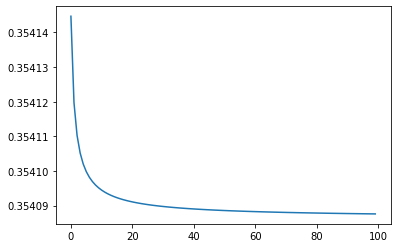

In [80]:
#Plot the error with epochs
import matplotlib.pyplot as plt
plt.plot(np.arange(epoch + 1), error )

**Train the Neural Network again by changing the number of epochs, learning rate, number of hidden layers, and size of training data**